In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.nn.utils.parametrize as parametrize
from tqdm import tqdm

## Hyperparameters

In [2]:
BATCH_SIZE = 200

TEST_SIZE = 0.2

N_EPOCH = 20
LEARNING_RATES = 0.001

torch.manual_seed(689)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

## Dataset preparations

In [3]:
from automata import *
from datas import even, sink, fix, unique

Generate dataset 'even'...
Done! in 7.6128 sec
Generate dataset 'sink'...
Done! in 49.6354 sec
Generate 'fix'...
Done! in 4.2903 sec
Generate 'unique'...
Done! in 3.9331 sec


In [4]:
def makeloader(automaton:DFA):
    train, test = random_split(TorchData(automaton), [1-TEST_SIZE, TEST_SIZE])

    train = DataLoader(train, BATCH_SIZE, shuffle=True)
    test = next(iter(DataLoader(test, len(test))))

    return train, test
    

evenloader, testeven = makeloader(even)

sinkloader, testsink = makeloader(sink)

In [5]:
torch.sum(testsink[2])/len(testsink[2])

tensor(0.5040)

## RNN training

In [6]:
class AutomataRNN(nn.Module):

    def __init__(self, automaton:DFA) -> None:
        super().__init__()
        self.automaton = automaton
        self.transshape = automaton.transition.shape
        self.hidden_size = self.transshape[0]*self.transshape[1]

        self.rnn = nn.RNN(self.transshape[1], self.hidden_size, num_layers=1, batch_first=True, device=device, bias=False)
        self.toclass = nn.Linear(self.hidden_size, 2, device=device, bias=False)

    def absinit(self):
        "Force the sign of the initial parameters to be in the desired shape."
        parameters = {"rnn.weight_ih_l0" : abs(self.state_dict()["rnn.weight_ih_l0"]),
                      "rnn.weight_hh_l0" : -abs(self.state_dict()["rnn.weight_hh_l0"]),
                      "toclass.weight" :  abs(self.state_dict()["toclass.weight"])}
        
        self.load_state_dict(parameters)    

    def forward(self, x, truelen):
        "`truelen` is a list of the real length of the sequence : that way we can recover the good prediction along the rnn"
        h0 = torch.zeros(1, x.shape[0], self.hidden_size).to(device)
        h0[:,:,0] = 1
        out, _ = self.rnn(x.to(device), h0)
        out = torch.stack([out[i, truelen[i] -1, :] for i in range(out.shape[0])]) #extract only the require prediction y for each batch
        return self.toclass(out)
        
    def predict(self, x, truelen):
        return torch.argmax(self(x, truelen), dim = 1)
    
    def strpredict(self, word:str):
        tensor = torch.tensor(self.automaton.word_to_matrix(word))
        return 

In [7]:
class HiddentoHidden(nn.Module):
    def __init__(self, RNN) -> None:
        super().__init__()
        self.transshape = RNN.transshape
        self.hidden_size = RNN.hidden_size

    def forward(self, X):
        cat = [X[:,i].reshape(-1,1).expand(-1, self.transshape[1])  for i in range(0, self.hidden_size, self.transshape[1])]
        return torch.cat(cat, dim=1)
        

class ParametrizeRNN(AutomataRNN):
    """
    RNN with parameters with the constraints find by volodimir for automata.
    """
    def __init__(self, automaton: DFA) -> None:
        super().__init__(automaton)
        statedict = self.state_dict()
        weight_hh = torch.zeros(*statedict["rnn.weight_hh_l0"].shape)
        for i in range(0, self.hidden_size, self.transshape[1]):
            weight_hh[:,i] = statedict["rnn.weight_hh_l0"][:,i]
            statedict["rnn.weight_ih_l0"][i:i+self.transshape[1]] = 2*torch.eye(self.transshape[1])
        self.load_state_dict(statedict)
        self.rnn.all_weights[0][0].requires_grad_(False) # turn off the optimization along weight_ih

        parametrize.register_parametrization(self.rnn, "weight_hh_l0", HiddentoHidden(self))

### Even

In [18]:
evenRNN = AutomataRNN(even).to(device)

loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(evenRNN.parameters(), lr=LEARNING_RATES)

losslist = list()

for epoch in range(N_EPOCH):
    trainer = iter(evenloader)
    for _ in tqdm(range(len(evenloader)), desc=f"Epoch {epoch+1}...", ncols=75):
        words, lengths, labels = next(trainer)

        out = evenRNN(words, lengths)

        losslist.append(loss(out, labels))
        losslist[-1].backward()

        optim.step()
        optim.zero_grad()

    with torch.no_grad():
        predictions = evenRNN.predict(testeven[0], testeven[1])
        acc = torch.sum(predictions == testeven[2].reshape(-1), dim=0) * 100 / len(testeven[2])
        print(f"Done! Trainloss: {losslist[-1]:.6f}, Test accuracy: {acc:.4f}")
        

Epoch 1...: 100%|██████████████████████████| 40/40 [00:00<00:00, 40.79it/s]


Done! Trainloss: 0.691986, Test accuracy: 50.4500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:00<00:00, 42.95it/s]


Done! Trainloss: 0.695615, Test accuracy: 50.1500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:00<00:00, 48.47it/s]


Done! Trainloss: 0.695815, Test accuracy: 49.6500


Epoch 4...: 100%|██████████████████████████| 40/40 [00:00<00:00, 48.81it/s]


Done! Trainloss: 0.694211, Test accuracy: 49.0500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:00<00:00, 48.02it/s]


Done! Trainloss: 0.694791, Test accuracy: 48.7000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:00<00:00, 44.59it/s]


Done! Trainloss: 0.694179, Test accuracy: 49.7000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:00<00:00, 48.00it/s]


Done! Trainloss: 0.692402, Test accuracy: 49.4500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:00<00:00, 48.30it/s]


Done! Trainloss: 0.692127, Test accuracy: 49.9000


Epoch 9...: 100%|██████████████████████████| 40/40 [00:00<00:00, 48.26it/s]


Done! Trainloss: 0.692854, Test accuracy: 50.4500


Epoch 10...: 100%|█████████████████████████| 40/40 [00:00<00:00, 48.63it/s]


Done! Trainloss: 0.693587, Test accuracy: 49.0000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:00<00:00, 46.74it/s]


Done! Trainloss: 0.691946, Test accuracy: 49.1500


Epoch 12...: 100%|█████████████████████████| 40/40 [00:00<00:00, 42.64it/s]


Done! Trainloss: 0.693271, Test accuracy: 48.9500


Epoch 13...: 100%|█████████████████████████| 40/40 [00:00<00:00, 48.43it/s]


Done! Trainloss: 0.693273, Test accuracy: 48.6500


Epoch 14...: 100%|█████████████████████████| 40/40 [00:00<00:00, 48.25it/s]


Done! Trainloss: 0.693651, Test accuracy: 50.3000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:00<00:00, 45.43it/s]


Done! Trainloss: 0.693411, Test accuracy: 48.8500


Epoch 16...: 100%|█████████████████████████| 40/40 [00:00<00:00, 48.58it/s]


Done! Trainloss: 0.692679, Test accuracy: 48.7000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:00<00:00, 48.77it/s]


Done! Trainloss: 0.692495, Test accuracy: 48.7000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:00<00:00, 48.46it/s]


Done! Trainloss: 0.693138, Test accuracy: 48.7000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:00<00:00, 48.92it/s]


Done! Trainloss: 0.692804, Test accuracy: 48.9000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:00<00:00, 47.69it/s]


Done! Trainloss: 0.694861, Test accuracy: 49.6000


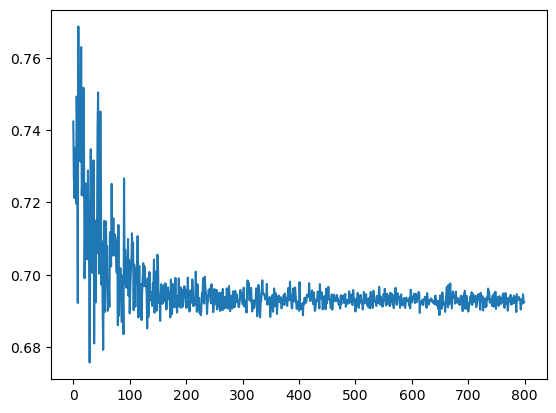

In [7]:
with torch.no_grad():
    plt.plot(losslist)
    plt.show()

### Sink

In [26]:
sinkRNN = AutomataRNN(sink).to(device)

loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(sinkRNN.parameters(), lr=LEARNING_RATES)

losslistnoinit = list()

for epoch in range(N_EPOCH):
    trainer = iter(sinkloader)
    for _ in tqdm(range(len(sinkloader)), desc=f"Epoch {epoch+1}...", ncols=75):
        words, lengths, labels = next(trainer)

        out = sinkRNN(words, lengths)

        losslistnoinit.append(loss(out, labels))
        losslistnoinit[-1].backward()

        optim.step()
        optim.zero_grad()

    with torch.no_grad():
        predictions = sinkRNN.predict(testsink[0], testsink[1])
        acc = torch.sum(predictions == testsink[2].reshape(-1), dim=0) * 100 / len(testsink[2])
        print(f"Done! Trainloss: {losslistnoinit[-1]:.6f}, Test accuracy: {acc:.4f}")


sinkRNN = AutomataRNN(sink).to(device)
sinkRNN.absinit()

loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(sinkRNN.parameters(), lr=LEARNING_RATES)

losslistinit = list()

for epoch in range(N_EPOCH):
    trainer = iter(sinkloader)
    for _ in tqdm(range(len(sinkloader)), desc=f"Epoch {epoch+1}...", ncols=75):
        words, lengths, labels = next(trainer)

        out = sinkRNN(words, lengths)

        losslistinit.append(loss(out, labels))
        losslistinit[-1].backward()

        optim.step()
        optim.zero_grad()

    with torch.no_grad():
        predictions = sinkRNN.predict(testsink[0], testsink[1])
        acc = torch.sum(predictions == testsink[2].reshape(-1), dim=0) * 100 / len(testsink[2])
        print(f"Done! Trainloss: {losslistinit[-1]:.6f}, Test accuracy: {acc:.4f}")
        

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.56it/s]


Done! Trainloss: 0.594802, Test accuracy: 66.5500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 29.94it/s]


Done! Trainloss: 0.482791, Test accuracy: 93.1000


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 26.51it/s]


Done! Trainloss: 0.369897, Test accuracy: 96.5000


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 31.41it/s]


Done! Trainloss: 0.266110, Test accuracy: 98.3500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 30.13it/s]


Done! Trainloss: 0.170753, Test accuracy: 99.0000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 22.58it/s]


Done! Trainloss: 0.126683, Test accuracy: 100.0000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 20.97it/s]


Done! Trainloss: 0.100963, Test accuracy: 100.0000


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 24.38it/s]


Done! Trainloss: 0.073099, Test accuracy: 99.9500


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 20.57it/s]


Done! Trainloss: 0.062200, Test accuracy: 100.0000


Epoch 10...: 100%|█████████████████████████| 40/40 [00:02<00:00, 16.78it/s]


Done! Trainloss: 0.043958, Test accuracy: 100.0000


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.16it/s]


Done! Trainloss: 0.038664, Test accuracy: 100.0000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 20.44it/s]


Done! Trainloss: 0.038458, Test accuracy: 100.0000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.04it/s]


Done! Trainloss: 0.021763, Test accuracy: 100.0000


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 31.04it/s]


Done! Trainloss: 0.021996, Test accuracy: 100.0000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 20.13it/s]


Done! Trainloss: 0.018498, Test accuracy: 100.0000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 25.59it/s]


Done! Trainloss: 0.018224, Test accuracy: 100.0000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.72it/s]


Done! Trainloss: 0.014182, Test accuracy: 100.0000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 31.77it/s]


Done! Trainloss: 0.015183, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 20.64it/s]


Done! Trainloss: 0.010113, Test accuracy: 100.0000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:02<00:00, 18.69it/s]


Done! Trainloss: 0.009026, Test accuracy: 100.0000


Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 24.28it/s]


Done! Trainloss: 0.690113, Test accuracy: 50.6500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 31.35it/s]


Done! Trainloss: 0.652622, Test accuracy: 89.7500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.78it/s]


Done! Trainloss: 0.547891, Test accuracy: 89.7500


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.35it/s]


Done! Trainloss: 0.391333, Test accuracy: 89.9000


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.60it/s]


Done! Trainloss: 0.279510, Test accuracy: 95.7000


Epoch 6...: 100%|██████████████████████████| 40/40 [00:01<00:00, 35.03it/s]


Done! Trainloss: 0.217883, Test accuracy: 96.5000


Epoch 7...: 100%|██████████████████████████| 40/40 [00:01<00:00, 34.07it/s]


Done! Trainloss: 0.137260, Test accuracy: 96.9500


Epoch 8...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.34it/s]


Done! Trainloss: 0.098415, Test accuracy: 97.1500


Epoch 9...: 100%|██████████████████████████| 40/40 [00:01<00:00, 32.70it/s]


Done! Trainloss: 0.066848, Test accuracy: 99.3500


Epoch 10...: 100%|█████████████████████████| 40/40 [00:01<00:00, 29.54it/s]


Done! Trainloss: 0.052992, Test accuracy: 99.9500


Epoch 11...: 100%|█████████████████████████| 40/40 [00:01<00:00, 24.17it/s]


Done! Trainloss: 0.045680, Test accuracy: 100.0000


Epoch 12...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.79it/s]


Done! Trainloss: 0.028358, Test accuracy: 100.0000


Epoch 13...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.67it/s]


Done! Trainloss: 0.027980, Test accuracy: 99.9500


Epoch 14...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.78it/s]


Done! Trainloss: 0.025756, Test accuracy: 100.0000


Epoch 15...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.47it/s]


Done! Trainloss: 0.024122, Test accuracy: 100.0000


Epoch 16...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.85it/s]


Done! Trainloss: 0.015281, Test accuracy: 100.0000


Epoch 17...: 100%|█████████████████████████| 40/40 [00:01<00:00, 34.06it/s]


Done! Trainloss: 0.017795, Test accuracy: 100.0000


Epoch 18...: 100%|█████████████████████████| 40/40 [00:01<00:00, 30.58it/s]


Done! Trainloss: 0.015764, Test accuracy: 100.0000


Epoch 19...: 100%|█████████████████████████| 40/40 [00:01<00:00, 33.99it/s]


Done! Trainloss: 0.013330, Test accuracy: 100.0000


Epoch 20...: 100%|█████████████████████████| 40/40 [00:01<00:00, 32.54it/s]


Done! Trainloss: 0.013494, Test accuracy: 100.0000


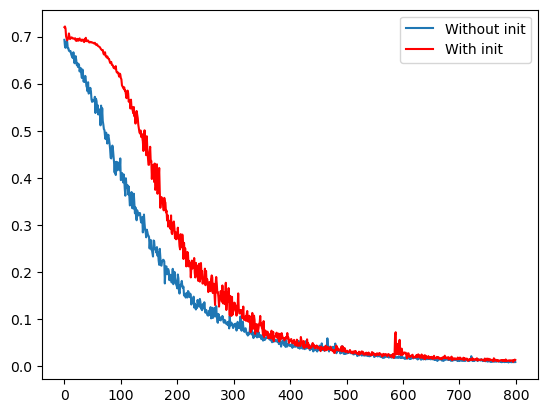

In [29]:
with torch.no_grad():
    plt.plot(losslistnoinit, label = "Without init")
    plt.plot(losslistinit, "r", label="With init")
    plt.legend()
    plt.show()
    

In [23]:
sink.probas = "equal"

sink.dataset(10000, meanlen = 12, max_try = 10000, random_state=690)

sinkmoretest = next(iter(DataLoader(TorchData(sink), 10000)))

with torch.no_grad():
    predictions = sinkRNN.predict(sinkmoretest[0], sinkmoretest[1])
    acc = torch.sum(predictions == sinkmoretest[2].reshape(-1), dim=0) * 100 / len(sinkmoretest[2])
    print(f"Test accuracy: {acc:.4f}")

/home/mt-ubu2/Documents/Internship/RNN_autmata/automata.py:321: UserWarning: `max_try` limit reach. Final prop = 0.0002
  warn(f"`max_try` limit reach. Final prop = {sum(labels)/len(labels)}")


In [8]:
sinkpRNN = ParametrizeRNN(sink)

loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(sinkpRNN.parameters(), lr=LEARNING_RATES)

losslistnoinit = list()

for epoch in range(N_EPOCH):
    trainer = iter(sinkloader)
    for _ in tqdm(range(len(sinkloader)), desc=f"Epoch {epoch+1}...", ncols=75):
        words, lengths, labels = next(trainer)

        out = sinkpRNN(words, lengths)

        losslistnoinit.append(loss(out, labels))
        losslistnoinit[-1].backward()

        optim.step()
        optim.zero_grad()

    with torch.no_grad():
        predictions = sinkpRNN.predict(testsink[0], testsink[1])
        acc = torch.sum(predictions == testsink[2].reshape(-1), dim=0) * 100 / len(testsink[2])
        print(f"Done! Trainloss: {losslistnoinit[-1]:.6f}, Test accuracy: {acc:.4f}")

Epoch 1...: 100%|██████████████████████████| 40/40 [00:01<00:00, 25.35it/s]


Done! Trainloss: 0.522348, Test accuracy: 80.2500


Epoch 2...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.73it/s]


Done! Trainloss: 0.423122, Test accuracy: 89.7500


Epoch 3...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.40it/s]


Done! Trainloss: 0.307563, Test accuracy: 89.7500


Epoch 4...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.62it/s]


Done! Trainloss: 0.254592, Test accuracy: 90.2500


Epoch 5...: 100%|██████████████████████████| 40/40 [00:01<00:00, 33.40it/s]


Done! Trainloss: 0.220282, Test accuracy: 94.2500


Epoch 6...:  45%|███████████▋              | 18/40 [00:00<00:00, 27.83it/s]


KeyboardInterrupt: 

In [33]:
sinkpRNN.state_dict()

OrderedDict([('rnn.weight_ih_l0',
              tensor([[2., 0., 0.],
                      [0., 2., 0.],
                      [0., 0., 2.],
                      [2., 0., 0.],
                      [0., 2., 0.],
                      [0., 0., 2.],
                      [2., 0., 0.],
                      [0., 2., 0.],
                      [0., 0., 2.],
                      [2., 0., 0.],
                      [0., 2., 0.],
                      [0., 0., 2.],
                      [2., 0., 0.],
                      [0., 2., 0.],
                      [0., 0., 2.]])),
             ('rnn.parametrizations.weight_hh_l0.original',
              tensor([[ 3.0350e-02,  8.1429e-02,  1.5326e-01,  3.1146e-01,  2.2061e-01,
                       -1.0504e-02,  3.9433e-01,  1.3945e-01, -1.3715e-02, -1.3643e-01,
                       -1.4261e-01,  9.4098e-02,  8.0064e-02,  9.9869e-02,  1.3513e-01],
                      [ 1.7059e-01, -1.8528e-01,  2.5554e-01, -1.2984e-01,  3.0299e-02,
          